# Mapping neighbourhood compost units in Amsterdam

In the last year [several worm hotels popped up in Amsterdam](https://www.amsterdam.nl/wonen-leefomgeving/zelfbeheer/compost-maken-buurt/). This grassroot initiative lets the neighbourhood turn green waste into compost.

Using [open data from the municipality of Amsterdam](https://data.amsterdam.nl), I will see what I can find out about these worm hotels. I will dig into the following:

### Where is the nearest worm hotel to my house?

* Show a map with the worm hotels and isochrones (isochrones are circles around a point that show the distance that can be traveled in a certain time)


### How reachable are the worm hotels for residences in Amsterdam?

* Use a routing machine to calculate the shortest walking duration and distance to the nearest worm hotel for all addresses in Amsterdam. Keep only residences (and throw out companies, schools, museums and the like).

* Create a function which takes in an address or coordinates, and returns the walking duration to the nearest worm hotel, and all information about the nearest worm hotel.

Then I can do things like:

* Calculate the percentage of residences within a 5 minute walk of a worm hotel, show histogram.

* Score neighbourhoods and boroughs on reachability. Take into account the population per neigbourhood. Show a choropleth with the scores.


#### Notes

* **Please note that this is a pet project and an exercise in using open data and software for data analysis. Advice about placement of worm hotels should be taken with a grain of salt: worm hotels have a limited number of participants. If you’re interested in joining a worm hotel, check [this website](https://www.amsterdam.nl/wonen-leefomgeving/zelfbeheer/compost-maken-buurt/), or use the function in this notebook to find out the nearest hotel and email address.**
* This should be relatively easy to generalize with any 2 datasets that have a 'location_cleaned' column with lng/lat coordinates as a single string, with a point as decimal seperator and comma as seperator between the coordinates.
* To look up the walking times for all addresses in Amsterdam, I use [OSRM](http://project-osrm.org/). I go the file for the Netherlands from [Geofabrik](http://www.geofabrik.de/), built it for the foot profile, and ran [the docker image provided by project-osrm](https://hub.docker.com/r/osrm/osrm-backend/) via [the docker application](https://www.docker.com/what-docker).
* I use the free tier of [openrouteservice.org](https://openrouteservice.org/) to calculate the Isochrones around the worm hotels.
* For mapping I use [Folium](https://github.com/python-visualization/folium), a Python wrapper for [Leaflet](http://leafletjs.com/).


#### Possible improvements

* The OSRM lookup could be much faster with duplicate detection. Pandas can then fill down the missing values.

* I would like to turn the data part into an API and run a web front end on this, to lookup addresses.

* I'd like to create a matrix optimization function that returns the perfect placement for a new hotel (probably inside a designated area). I think I need to cover the area in random points, and pick the one with the greatest walking distance to all nearby wormhotels. 

#### Datasets used

* [Addresses in Amsterdam](https://data.amsterdam.nl/index.html#?dsd=bag&dsp=1&dsv=TABLE&mpb=topografie&mpz=11&mpv=52.3731081:4.8932945)
* [Neighbourhood compost map and data](https://maps.amsterdam.nl/open_geodata/?LANG=en)
* [Population data Amsterdam](https://data.amsterdam.nl/#?dte=catalogus%2Fapi%2F3%2Faction%2Fpackage_show%3Fid%3Db51154d8-2eca-4dd9-932d-63bca9ef0bf2&dtfs=T&dsf=groups::bevolking&mpb=topografie&mpz=11&mpv=52.3731081:4.8932945)
* [GeoJSON of 'gebieden' (larger neighbourhoods) in Amsterdam](https://maps.amsterdam.nl/open_geodata/?LANG=nl) (simplified with [Mapshaper](http://mapshaper.org/))

In [57]:
import numpy as np
import pandas as pd
import requests
import folium
from folium.plugins import HeatMap
import geojson
import seaborn as sns
from decimal import Decimal, ROUND_HALF_UP



# set interactivity to 'all' so I can easily print more than 1 outputs in 1 cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Supress 'SettingWithCopyWarning'
pd.options.mode.chained_assignment = None  # default='warn'

## 1. Nearest worm hotel to my house

### 1.1 Preparing the data

In [2]:
# Load afvalcontainers from Amsterdam site
df_buurtcompost_import = pd.read_csv('http://maps.amsterdam.nl/open_geodata/excel.php?KAARTLAAG=BUURTCOMPOST&THEMA=buurtcompost', encoding='latin-1', sep=";")
df_buurtcompost = df_buurtcompost_import

In [3]:
# Clean up the coordinates column. I need a string formatted a coord string 
# with decimals points, comma seperated, formatted as '{lng},{lat}'.
df_buurtcompost = df_buurtcompost_import
df_buurtcompost['locatie_cleaned'] = df_buurtcompost_import['COORDS'].str.replace('POINT\(','').str.replace('\)','')

In [4]:
# Create a function to create lng and lat float columns from 'location_cleaned' column
def create_lng_lat_columns ( df ) :
    df['lng'] = df['LNG'].str.replace(',','.').astype(float)
    df['lat'] = df['LAT'].str.replace(',','.').astype(float)
    return df

df_buurtcompost = create_lng_lat_columns(df_buurtcompost)
df_buurtcompost.head()

OBJECTNUMMER                           Straatnaam        Initiatiefnemer  \
0             4                     Frans Halsstraat      Peter Jan Brouwer   
1             5  hoek saffierstraat jozef israelkade     christien & anneke   
2             6                   zaanstraat t/o 300     soeptuinen bredius   
3             7                         kramatweg 51     oost indisch groen   
4             8                              IJplein  buurtbak voedseltuin    

                           Email  Aantal_bewoners Soort_afval  \
0  amsterdam+C001@wormenhotel.nl               20          GF   
1  amsterdam+c002@wormenhotel.nl                7          GF   
2              www.soeptuinen.nl                0         GFT   
3      info@oostindischgroen.nl                 0         GFT   
4            ireen@balkonton.nl                 6          GF   

                           Gebruik  Startjaar              Foto  \
0  Toestemming van initiatiefnemer       2015  frans hals .jpeg   
1  Toestemming van initiatiefnemer       2016               NaN   
2                   Vrij inleveren       2016               NaN   
3                   Vrij inleveren       2016               NaN   
4  Toestemming van initiatiefnemer       2016               NaN   

                      COORDS       LNG        LAT  Unnamed: 12  \
0  POINT(4.888706,52.356007)  4,888706  52,356007          NaN   
1  POINT(4.908527,52.349857)  4,908527  52,349857          NaN   
2  POINT(4.871422,52.391292)  4,871422  52,391292          NaN   
3   POINT(4.945789,52.36213)  4,945789   52,36213          NaN   
4  POINT(4.910984,52.382154)  4,910984  52,382154          NaN   

      locatie_cleaned       lng        lat  
0  4.888706,52.356007  4.888706  52.356007  
1  4.908527,52.349857  4.908527  52.349857  
2  4.871422,52.391292  4.871422  52.391292  
3   4.945789,52.36213  4.945789  52.362130  
4  4.910984,52.382154  4.910984  52.382154

### 1.2 Where are these hotels?

Let's do some mapping! I'll use Folium to plot all hotels, and also plot the approximate location to myet house in Amsterdam.


In [5]:
# Temporarily turn of showing all output for folium mapping, needs to be in seperate cell
InteractiveShell.ast_node_interactivity = "last_expr"

In [6]:
buurtcompostlocaties_markers = list(zip(df_buurtcompost.lat.values, df_buurtcompost.lng.values, df_buurtcompost.Straatnaam))
hmap = folium.Map(location=[52.3824856,4.877951499999995], zoom_start=12, tiles='stamentoner',)

feature_group = folium.FeatureGroup("Locations")
for lat, lon, name in buurtcompostlocaties_markers:
    feature_group.add_child(folium.Marker(location=[lat,lon],popup=name))

my_house = folium.FeatureGroup("Locations")
my_house.add_child(folium.Marker([52.381994, 4.876480], popup="My house (approx.)", icon=folium.Icon(color='red',icon='info-sign')))    
    
hmap.add_child(my_house)
hmap.add_child(feature_group)

I can see a worm hotel is near the house (it's so closeby the red marker is obscured by it).

## 2. How reachable are the worm hotels for everyone living in Amsterdam?

First, let's see the how much over Amsterdam is covered within a 5 minute walk from the worm hotels by looking at some [isochrones](https://en.wikipedia.org/wiki/Isochrone_map).

### 2.1 Mapping Isochrones of 5 minute walks around the worm hotels

There is no way to plot Isochrones with OSRM, so I'll use the [Openrouteservice](https://openrouteservice.org/) instead. It only allows 5 calls at a time for their free tier, so this will be a bit clunky.

In [7]:
InteractiveShell.ast_node_interactivity = "all" # Turn on all output again

In [8]:
# Create array with coords in format [['lat,lng'], ['lat,lng']]
buurtcompostlocaties_arrays = list(df_buurtcompost.locatie_cleaned)
# Divide length by 5 to see how many calls I need to make to openrouteservice.org. Shows 7.8, so 8 calls.
len(buurtcompostlocaties_arrays) / 5
# Put groups of 3-5 coordinates together in an array for building the API request URLs
buurtcompostlocaties_arrays_5 = [buurtcompostlocaties_arrays[i:i+5] for i  in range(0, len(buurtcompostlocaties_arrays), 5)]
# print('Calls I need to make to openrouteservice API: ' + str(len(buurtcompostlocaties_arrays_5))) # Shows 8

7.8

In [9]:
# Create a function to create the GeoJSON files with isochrones
def create_isochrone_json(range_seconds, filename):

    isochrone_features = []

    for i in range(len(buurtcompostlocaties_arrays_5)):
        coords = '|'.join(buurtcompostlocaties_arrays_5[i])
        requestURL = 'https://private-anon-e7e15c7342-openrouteservice.apiary-proxy.com/isochrones' + \
        '?api_key=58d904a497c67e00015b45fc892c214578cd4fae9ea5f36e23e8cb2f&profile=foot-walking' + \
        '&range=' + range_seconds + '&location_type=destination&locations=' + coords
        features = requests.get(requestURL).json()['features']
        isochrone_features.append(features)

        isochrone_featurecollection = {
            "type": "FeatureCollection",
            "features": []
        }

    for i in range(len(isochrone_features)):
                   isochrone_featurecollection['features'].extend(isochrone_features[i])

    with open(filename, 'w') as file:
        geojson.dump(isochrone_featurecollection, file, indent=4, sort_keys=False)

# Create isochrone GeoJSON
create_isochrone_json('300', 'data/isochrone_featurecollection_300.geojson')
create_isochrone_json('600', 'data/isochrone_featurecollection_600.geojson')

In [10]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [11]:
buurtcompostlocaties_markers = list(zip(df_buurtcompost.lat.values, df_buurtcompost.lng.values, df_buurtcompost.Straatnaam))
hmap = folium.Map(location=[52.3824856,4.877951499999995], zoom_start=12, tiles='stamentoner',)

feature_group = folium.FeatureGroup("Locations")
for lat, lon, name in buurtcompostlocaties_markers:
    feature_group.add_child(folium.Marker(location=[lat,lon],popup=name))
    hmap.add_child(feature_group)

folium.GeoJson(open("data/isochrone_featurecollection_300.geojson",encoding = "utf-8-sig").read(), name='geojson').add_to(hmap)
# folium.GeoJson(open("data/isochrone_featurecollection_600.geojson",encoding = "utf-8-sig").read(), name='geojson').add_to(hmap)

hmap

In [12]:
InteractiveShell.ast_node_interactivity = "all" # Turn on all output again

Some neighbourhoods have decent coverage. It's notable that the city center does not have any hotels. Let's look at the data on all addresses in Amsterdam!



### 2.2 Loading in all addresses in Amsterdam

In [13]:
# Loading from disk because file is 17mb, loading from site takes too long
df_adressen = pd.read_csv('data/export_20180227_122333.zip', encoding='latin-1', sep=";")
# Convert lat and long values to float
df_adressen['lng'] = df_adressen['Longitude (WGS84)'].str.replace(',', '.').astype(float)
df_adressen['lat'] = df_adressen['Latitude (WGS84)'].str.replace(',', '.').astype(float)
# A few rows have NaN as longtitude or lattitude, let's remove those
df_adressen = df_adressen[pd.notnull(df_adressen['lng'])]
df_adressen = df_adressen[pd.notnull(df_adressen['lat'])]
# Now combine the coordinates into a string
df_adressen['locatie_cleaned'] = df_adressen['lng'].map(str) + "," + df_adressen['lat'].map(str)
df_adressen.head()
df_adressen['locatie_cleaned'].describe()

Naam openbare ruimte  Huisnummer Huisletter  \
0  Eerste Constantijn Huygensstraat          15        NaN   
1              Eerste Helmersstraat         188        NaN   
2       Eerste Anjeliersdwarsstraat           1        NaN   
3  Eerste Constantijn Huygensstraat          19        NaN   
4              Eerste Helmersstraat         190        NaN   

  Huisnummertoevoeging Postcode  Woonplaats Naam stadsdeel Code stadsdeel  \
0                    1   1054BP         NaN           West              E   
1                    3   1054EL         NaN           West              E   
2                    2   1015NR         NaN        Centrum              A   
3                    2   1054BP         NaN           West              E   
4                    3   1054EL         NaN           West              E   

  Naam gebiedsgerichtwerkengebied Code gebiedsgerichtwerkengebied  \
0          Oud West / De Baarsjes                            DX05   
1          Oud West / De Baarsjes                            DX05   
2                    Centrum-West                            DX01   
3          Oud West / De Baarsjes                            DX05   
4          Oud West / De Baarsjes                            DX05   

           ...                Verblijfsobjectstatus  \
0          ...           Verblijfsobject in gebruik   
1          ...           Verblijfsobject in gebruik   
2          ...           Verblijfsobject in gebruik   
3          ...           Verblijfsobject in gebruik   
4          ...           Verblijfsobject in gebruik   

  Openbareruimte-identificatie     Pandidentificatie  \
0              363300000002537  ['0363100012159829']   
1              363300000002541  ['0363100012120031']   
2              363300000002529  ['0363100012174784']   
3              363300000002537  ['0363100012157570']   
4              363300000002541  ['0363100012120432']   

  Verblijfsobjectidentificatie Ligplaatsidentificatie  \
0                 3.630100e+14                    NaN   
1                 3.630100e+14                    NaN   
2                 3.630100e+14                    NaN   
3                 3.630100e+14                    NaN   
4                 3.630100e+14                    NaN   

   Standplaatsidentificatie  Nummeraanduidingidentificatie       lng  \
0                       NaN                363200000007060  4.874401   
1                       NaN                363200000007846  4.864202   
2                       NaN                363200000006112  4.883470   
3                       NaN                363200000007066  4.874329   
4                       NaN                363200000007852  4.864099   

         lat       locatie_cleaned  
0  52.364906  4.8744013,52.3649059  
1  52.360826  4.8642015,52.3608257  
2  52.378220  4.8834704,52.3782196  
3  52.364798  4.8743292,52.3647977  
4  52.360816  4.8640988,52.3608163  

[5 rows x 34 columns]

count                   510436
unique                  314880
top       4.8507211,52.3574849
freq                       145
Name: locatie_cleaned, dtype: object

### 2.3 Which residences are within the 5-minute isochrones?

Let's calculate who lives inside the isochrones I calculated earlier. Using [the even–odd rule](https://en.wikipedia.org/wiki/Even–odd_rule) I can determine if a point is inside a polygon or not.

In [14]:
# Put geojson in variable
with open('data/isochrone_featurecollection_300.geojson') as geojson_file:    
     isochrones_300 = geojson.load(geojson_file)

In [15]:
# Create even-odd rule function, see https://en.wikipedia.org/wiki/Even–odd_rule
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                  (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [16]:
# Create function that outputs an Array with the names of the nearest worm hotel, or 'Not found'
def is_point_in_isochrones(isochrone_geojson,lng,lat):
    geos = []
    for i in range(len(isochrone_geojson['features'])):
        geos.append(list(geojson.utils.coords(isochrone_geojson['features'][i])))
    coordinates = []
    for i in range(len(geos)):
        if is_point_in_path(lng,lat,geos[i]):
            coordinates.append(df_buurtcompost.Straatnaam.iloc[i])
    return coordinates or ["Not found"]

# Create a function with a single argument I can apply to the pandas dataframe
def is_point_in_isochrones_300(locatie_cleaned):
    isochrone_geojson = isochrones_300
    array_string = locatie_cleaned.split(',')
    lng = float(array_string[0])
    lat = float(array_string[1])
    return is_point_in_isochrones(isochrone_geojson, lng, lat)

#### Test the function

In [17]:
is_point_in_isochrones(isochrones_300, 4.876480, 52.381994) # Near my house
is_point_in_isochrones(isochrones_300, 4.88718,52.357117) # Address which is within 3 polygons
is_point_in_isochrones_300(df_adressen.locatie_cleaned[4433]) # Testing the function to use with Pandas

['hoek jacob catskade - de wittenstraat']

['Frans Halsstraat', 'daniel stalpertstraat', 'quellijnstraat']

['Frans Halsstraat', 'sarphatipark/sweelinckstraat']

#### Apply function to all addresses

In [18]:
# Calculate this for all residences. Warning: this will take a while (10 minutes on my computer)
df_adressen['wormhotel_within_5_minutes'] = df_adressen['locatie_cleaned'].apply(
    np.vectorize(is_point_in_isochrones_300))


In [23]:
df_adressen.head()

Naam openbare ruimte  Huisnummer Huisletter  \
0  Eerste Constantijn Huygensstraat          15        NaN   
1              Eerste Helmersstraat         188        NaN   
2       Eerste Anjeliersdwarsstraat           1        NaN   
3  Eerste Constantijn Huygensstraat          19        NaN   
4              Eerste Helmersstraat         190        NaN   

  Huisnummertoevoeging Postcode  Woonplaats Naam stadsdeel Code stadsdeel  \
0                    1   1054BP         NaN           West              E   
1                    3   1054EL         NaN           West              E   
2                    2   1015NR         NaN        Centrum              A   
3                    2   1054BP         NaN           West              E   
4                    3   1054EL         NaN           West              E   

  Naam gebiedsgerichtwerkengebied Code gebiedsgerichtwerkengebied  \
0          Oud West / De Baarsjes                            DX05   
1          Oud West / De Baarsjes                            DX05   
2                    Centrum-West                            DX01   
3          Oud West / De Baarsjes                            DX05   
4          Oud West / De Baarsjes                            DX05   

               ...                   Pandidentificatie  \
0              ...                ['0363100012159829']   
1              ...                ['0363100012120031']   
2              ...                ['0363100012174784']   
3              ...                ['0363100012157570']   
4              ...                ['0363100012120432']   

  Verblijfsobjectidentificatie Ligplaatsidentificatie  \
0                 3.630100e+14                    NaN   
1                 3.630100e+14                    NaN   
2                 3.630100e+14                    NaN   
3                 3.630100e+14                    NaN   
4                 3.630100e+14                    NaN   

  Standplaatsidentificatie Nummeraanduidingidentificatie       lng        lat  \
0                      NaN               363200000007060  4.874401  52.364906   
1                      NaN               363200000007846  4.864202  52.360826   
2                      NaN               363200000006112  4.883470  52.378220   
3                      NaN               363200000007066  4.874329  52.364798   
4                      NaN               363200000007852  4.864099  52.360816   

        locatie_cleaned wormhotel_within_5_minutes  \
0  4.8744013,52.3649059                [Not found]   
1  4.8642015,52.3608257                [Not found]   
2  4.8834704,52.3782196                [Not found]   
3  4.8743292,52.3647977                [Not found]   
4  4.8640988,52.3608163                [Not found]   

   is_wormhotel_within_5_minutes  
0                          False  
1                          False  
2                          False  
3                          False  
4                          False  

[5 rows x 36 columns]

In [24]:
# Also create a true/false column for easy plotting
def wormhotel_within_5_minutes_true_false(array):
    if array[0] == "Not found":
        return False
    else:
        return True

df_adressen['is_wormhotel_within_5_minutes'] = df_adressen['wormhotel_within_5_minutes'].apply(wormhotel_within_5_minutes_true_false)

#### Plot: how many people are within a 5 minute walk according to the isochrones?

We're only interested in residences (addresses where people live). Let's select those.

In [25]:
df_adressen_woning = df_adressen[df_adressen['Feitelijk gebruik'].str.contains("woning", na=False)]

438028

False    334765
True     103263
Name: is_wormhotel_within_5_minutes, dtype: int64

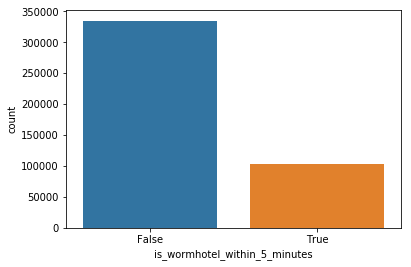

In [26]:
len(df_adressen_woning)
df_adressen_woning.is_wormhotel_within_5_minutes.value_counts()
p = sns.countplot(data=df_adressen_woning, x = 'is_wormhotel_within_5_minutes')

This is quite surprising! 24% of all residence addresses are within a 5 minute walk of a worm hotel.



### 2.4 Calculating a route to the nearest worm hotel for all addresses with OSRM

Seeing which addresses are within a 5 minute walk from a worm hotel is a nice start, but let's go deeper! I can calculate how far **every** address needs to walk to the nearest worm hotel. If I know this, I can be much more precise in 

To get walking distances for all addresses, I need a routing service. I installed the excellent OSRM project locally with docker via http://router.project-osrm.org/ and used the latest information for
The Netherlands via http://download.geofabrik.de.

OSRM lets you create a matrix that shows the walking duration for a series of points. I can create a 1 by many matrix for each address, and pick out the worm hotel with the shortest walking duration. The OSMR [doesn't return distance](https://github.com/Project-OSRM/osrm-backend/issues/1353), but since walking speed is set at 5 km/h by default and walking penalties are only given for sandy terrain and the like, I can reasonably calculate the distance in meters from the duration information.

I'll first explore how to get the right information from the API, and then create a function which picks the nearest worm hotel for an address, and also prints the walking duration in minutes and distance in meters.

#### First some exploration by hand


In [33]:
close_to_my_address = "4.877951499999995,52.3824856"
close_to_my_address = "4.876480,52.381994"
buurtcompostlocaties = df_buurtcompost.locatie_cleaned.values
buurtcompostlocaties_string = ";".join(buurtcompostlocaties)

profile = "foot"

# URL format for a htpp API call for getting a matrix is http://0.0.0.0:5000/table/v1/walking/
# 52.3548300687;4.7856975691585,52.349415837928;4.7941351619763,52.357223885252?sources=0
# 'sources=0' indicates that I only want the distances from the first set of coordinates
# to all the others. As a test I construct a URL that gives me the walking duration from my
# address to all the worm hotels.
 
testURL_wormhotel_distance_from_my_address = "http://0.0.0.0:5000/table/v1/" + profile + "/" \
                                        + close_to_my_address + ";" \
                                        + buurtcompostlocaties_string \
                                        + "?sources=0"
                      
print("Example of URL to send the API call with: " + testURL_wormhotel_distance_from_my_address)


# Let's run a request and only select the duration array
import requests
distances_from_testURL = requests.get(testURL_wormhotel_distance_from_my_address).json()["durations"][0]

# This gives us a durations array. The first is 0 and the duration to my own address, so I can remove that:
distances_from_testURL.pop(0)
print("All distances I get from the test url: " + str(distances_from_testURL))

# Give us the duration and the index of the wormhotel that's closest
print("Index of the wormhotel in the wormhotel dataset: " + str(distances_from_testURL.index(min(distances_from_testURL))))
print("Seconds I have to walk to the nearest hotel: " + str(min(distances_from_testURL)))

# Let's find out where the nearest wormhotel to my house is! 🎉
df_buurtcompost.iloc[33]

Example of URL to send the API call with: http://0.0.0.0:5000/table/v1/foot/4.876480,52.381994;4.888706,52.356007;4.908527,52.349857;4.871422,52.391292;4.945789,52.36213;4.910984,52.382154;4.864346,52.3687925;4.926176,52.3370046;4.971355,52.37154;5.004663,52.345872;4.861766,52.376636;4.923331,52.366302;4.9177,52.351515;4.887118,52.356278;4.887075,52.35694;5.000672,52.353723;4.9758081,52.3612775;4.9457027,52.3681734;4.9939396,52.3572812;4.9520167,52.3340925;4.877403,52.313325;4.9121,52.3511739;4.8247244,52.3604001;4.8815228,52.3514622;4.9442745,52.3920048;4.9464001,52.3773338;4.8999979,52.4053634;4.9392225,52.3594959;4.7711392,52.3800813;4.9461426,52.3742948;4.8538532,52.3676329;4.8515358,52.2839112;4.9365725,52.3703089;4.8761048,52.3900331;4.8761638,52.3813059;4.8487945,52.3403283;4.8980131,52.355381;4.9840798,52.2981711;4.9370124,52.3571305;4.9071004,52.3491685?sources=0


0

All distances I get from the test url: [2602, 3748.6, 1119.6, 4334.4, 2271.9, 1586.6, 5376.6, 7132.4, 8087.9, 1292, 3097.4, 4021.7, 2553.4, 2505, 8017.2, 5816.8, 4204.5, 8434.5, 6620.2, 7349.9, 3681.9, 3936.7, 2952.7, 4164.8, 4094.8, 4238.1, 4239.7, 5938.3, 3923.9, 2215.6, 9138.1, 3642.4, 891.9, 59.4, 4627.8, 2997.8, 10855.8, 4395.8, 3726.4]
Index of the wormhotel in the wormhotel dataset: 33
Seconds I have to walk to the nearest hotel: 59.4


OBJECTNUMMER                                          42
Straatnaam         hoek jacob catskade - de wittenstraat
Initiatiefnemer                                    hilde
Email                      amsterdam+a209@wormenhotel.nl
Aantal_bewoners                                       15
Soort_afval                                           GF
Gebruik                  Toestemming van initiatiefnemer
Startjaar                                           2017
Foto                                                 NaN
COORDS                       POINT(4.8761638,52.3813059)
LNG                                            4,8761638
LAT                                           52,3813059
Unnamed: 12                                          NaN
locatie_cleaned                     4.8761638,52.3813059
lng                                              4.87616
lat                                              52.3813
Name: 33, dtype: object



Turns out I only have to walk a minute to the nearest hotel!

#### Creating a function

Let's wrap this up in a function so I can encode the whole dataset with this information.

In [40]:
buurtcompostlocaties = df_buurtcompost.locatie_cleaned.values
buurtcompostlocaties_string = ";".join(buurtcompostlocaties)

len(buurtcompostlocaties)

def compute_nearest_target_information(cell):
    current_coordinates = cell
    profile = "foot"
    requestURL = "http://0.0.0.0:5000/table/v1/" + profile + "/" \
                                        + current_coordinates + ";" \
                                        + buurtcompostlocaties_string \
                                        + "?sources=0"
    distances = requests.get(requestURL).json()["durations"][0]
    distances.pop(0)
    seconds = min(distances)
    meters = seconds * 1.388888889
    index = distances.index(min(distances))
    buurtcompost_values = df_buurtcompost.iloc[index].values    
    return (seconds, meters, index, buurtcompost_values)


In [43]:
# Test output with my and someone else's house (or rather near it)
compute_nearest_target_information("4.877951499999995,52.3824856")
compute_nearest_target_information("4.8796727,52.3712739")

(162.2,
 225.27777779579998,
 33,
 array([42, 'hoek jacob catskade - de wittenstraat', 'hilde',
        'amsterdam+a209@wormenhotel.nl', 15, 'GF',
        'Toestemming van initiatiefnemer', 2017, nan,
        'POINT(4.8761638,52.3813059)', '4,8761638', '52,3813059', nan,
        '4.8761638,52.3813059', 4.8761637999999996, 52.381305900000001], dtype=object))

(949.3, 1318.4722223277, 5, array([9, 'schimmelstraat 44',
        'stadsboerderij zimmerhoeve, annelijn van amsterdam',
        'info@zimmerhoeve.nl', 0, 'GF', 'Toestemming van initiatiefnemer',
        0, nan, 'POINT(4.864346,52.3687925)', '4,864346', '52,3687925', nan,
        '4.864346,52.3687925', 4.8643460000000003, 52.368792499999998], dtype=object))

**Success!**

#### Applying the router to all addresses in Amsterdam

Neat! Now I can apply this function to the addresses in Amsterdam. First, lets apply this to small amount of people and also time it, so I can see how long our computer needs to work on the whole dataset.

*Note: Because this takes a while, I ran this seperately and wrote the output to a CSV, which I'll import here instead.*

In [32]:
# %%time
# df_adressen.is_copy = False
# df_adressen['Nearest wormhotel information'] = df_adressen['locatie_cleaned'].apply(
#     np.vectorize(compute_nearest_target_information))



I now need to split the output from the function over new columns in the dataset. I also add the information from the nearest hotel as new columns to the dataset.

In [36]:
# # Let's split it! Value inside df_adressen['Nearest wormhotel information'] are
# # 'seconds, meters, index, buurtcompost_values', and buurtcompostvalues are
# #  'OBJECTNUMMER', 'Straatnaam', 'Initiatiefnemer', 'Email', 'Aantal_bewoners', 'Soort_afval',
# # 'Gebruik', 'Startjaar', 'Foto', 'COORDS', 'LNG', 'LAT', 'Unnamed: 12', 'locatie_cleaned''

# df_adressen['nearest_hotel_duration'], df_adressen['nearest_hotel_meters'], df_adressen[
#     'nearest_hotel_index'], df_adressen['nearest_hotel_values'] = zip(*df_adressen['Nearest wormhotel information'])

# df_adressen['hotel_OBJECTNUMMER'], df_adressen['hotel_Straatnaam'], df_adressen['hotel_Initiatiefnemer'], \
#     df_adressen['hotel_Email'], df_adressen['hotel_Aantal_bewoners'], df_adressen['hotel_Soort_afval', ], \
#     df_adressen['hotel_Gebruik'], df_adressen['hotel_Startjaar'], df_adressen['hotel_Foto'], \
#     df_adressen['hotel_COORDS'], df_adressen['hotel_LNG'], df_adressen['hotel_LAT'], df_adressen['hotel_Unnamed: 12'], \
#     df_adressen['hotel_locatie_cleaned'], df_adressen['hotel_lng'], df_adressen['hotel_lat'] = zip(*df_adressen['nearest_hotel_values'])

# df_adressen.to_csv('data/df_adressen.csv')


In [18]:
# Using zip to bypass github's filesize limit of 100mb
df_adressen = pd.read_csv('data/df_adressen.zip')
df_adressen_woning = df_adressen[df_adressen['Feitelijk gebruik'].str.contains("woning", na=False)]
df_adressen_woning.tail()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1 Naam openbare ruimte  \
509940      509940        509940          509992     Goudsbloemstraat   
510067      510067        510067          510119  John Franklinstraat   
510117      510117        510117          510169         Retiefstraat   
510188      510188        510188          510240   Tweede Atjehstraat   
510354      510354        510354          510406    De Lairessestraat   

        Huisnummer Huisletter Huisnummertoevoeging Postcode  Woonplaats  \
509940          91        NaN                    1   1015JK         NaN   
510067          69        NaN                    H   1056TA         NaN   
510117          22          A                  NaN   1092XD         NaN   
510188          40        NaN                    4   1094LH         NaN   
510354          13          A                  NaN   1071NR         NaN   

       Naam stadsdeel              ...                     hotel_Foto  \
509940        Centrum              ...                            NaN   
510067           West              ...                magalhaens.jpeg   
510117           Oost              ...                            NaN   
510188           Oost              ...                     halma.jpeg   
510354           Zuid              ...                  hartmonie.jpg   

                       hotel_COORDS  hotel_LNG   hotel_LAT hotel_Unnamed: 12  \
509940  POINT(4.8761638,52.3813059)  4,8761638  52,3813059               NaN   
510067  POINT(4.8538532,52.3676329)  4,8538532  52,3676329               NaN   
510117      POINT(4.9177,52.351515)     4,9177   52,351515               NaN   
510188  POINT(4.9392225,52.3594959)  4,9392225  52,3594959               NaN   
510354  POINT(4.8815228,52.3514622)  4,8815228  52,3514622               NaN   

       hotel_locatie_cleaned hotel_lng  hotel_lat  wormhotel_within_5_minutes  \
509940  4.8761638,52.3813059  4.876164  52.381306               ['Not found']   
510067  4.8538532,52.3676329  4.853853  52.367633               ['Not found']   
510117      4.9177,52.351515  4.917700  52.351515               ['Not found']   
510188  4.9392225,52.3594959  4.939222  52.359496               ['Not found']   
510354  4.8815228,52.3514622  4.881523  52.351462               ['Not found']   

        is_wormhotel_within_5_minutes  
509940                          False  
510067                          False  
510117                          False  
510188                          False  
510354                          False  

[5 rows x 60 columns]

The address dataset is complete!

### 2.5 Fast lookup of worm hotel closest to address

Now I can build a simple function which queries the dataset for a streetname and number, and returns information about the nearest worm hotel:




In [67]:
def lookup_nearest_worm_hotel(straatnaam, nummer):
    index = 0
    index = df_adressen_woning.loc[(df_adressen_woning['Naam openbare ruimte'] == straatnaam) & (df_adressen_woning['Huisnummer'] == nummer)].nearest_hotel_index
    if len(index) == 0:
        return "Nothing found"
    else:
        duration = df_adressen_woning.loc[(df_adressen_woning['Naam openbare ruimte'] == straatnaam) & (df_adressen_woning['Huisnummer'] == nummer)].nearest_hotel_duration.iloc[0]
        hotel_name = df_adressen_woning.loc[(df_adressen_woning['Naam openbare ruimte'] == straatnaam) & (df_adressen_woning['Huisnummer'] == nummer)].hotel_Straatnaam.iloc[0]
        contact = df_adressen_woning.loc[(df_adressen_woning['Naam openbare ruimte'] == straatnaam) & (df_adressen_woning['Huisnummer'] == nummer)].hotel_Email.iloc[0]
        latlong = str(df_adressen_woning.loc[(df_adressen_woning['Naam openbare ruimte'] == straatnaam) & (df_adressen_woning['Huisnummer'] == nummer)].hotel_lat.iloc[0]) + "," + str(df_adressen_woning.loc[(df_adressen_woning['Naam openbare ruimte'] == straatnaam) & (df_adressen_woning['Huisnummer'] == nummer)].hotel_lng.iloc[0])
        return "Nearest Worm hotel name: " + hotel_name + ", Walking duration: " + str(round(duration / 60,2)) + " minutes. Contact " + str(contact) + " for more information. Google maps URL: http://maps.google.com/maps?q=" + str(latlong) + " ."

lookup_nearest_worm_hotel("De Wittenstraat",174)

lookup_nearest_worm_hotel("Lauriergracht",112)

lookup_nearest_worm_hotel("The Wittenstraat",172) # Intentionally incorrect streetname to test error handling

lookup_nearest_worm_hotel("Groenburgwal", 1)

'Nearest Worm hotel name: hoek jacob catskade - de wittenstraat, Walking duration: 0.82 minutes. Contact amsterdam+a209@wormenhotel.nl for more information. Google maps URL: http://maps.google.com/maps?q=52.3813059,4.8761638 .'

'Nearest Worm hotel name: schimmelstraat 44, Walking duration: 15.83 minutes. Contact info@zimmerhoeve.nl for more information. Google maps URL: http://maps.google.com/maps?q=52.3687925,4.864346 .'

'Nothing found'

'Nearest Worm hotel name: sarphatipark/sweelinckstraat, Walking duration: 23.79 minutes. Contact wormenhotelsweelinck@gmail.com for more information. Google maps URL: http://maps.google.com/maps?q=52.355381,4.8980131 .'

### 2.6 Comparison of the OSRM and Openrouteservice calculations

Let's see if the numbers from the isochrones compare to the information I have now.

438028

False    334765
True     103263
Name: is_wormhotel_within_5_minutes, dtype: int64

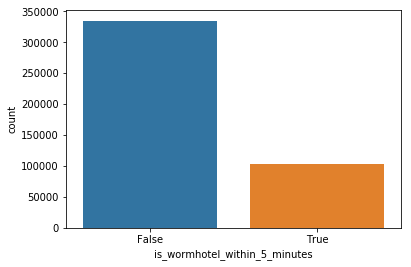

In [38]:
len(df_adressen_woning)
df_adressen_woning.is_wormhotel_within_5_minutes.value_counts()
isochrones = sns.countplot(data=df_adressen_woning, x = 'is_wormhotel_within_5_minutes')

438028

False    386897
True      51131
Name: nearest_hotel_duration_under_300, dtype: int64

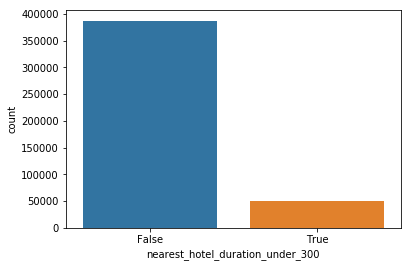

In [39]:
df_adressen_woning['nearest_hotel_duration_under_300'] = df_adressen_woning['nearest_hotel_duration'].transform(lambda x: x < 300.5)
len(df_adressen_woning)
df_adressen_woning.nearest_hotel_duration_under_300.value_counts()

p = sns.countplot(data=df_adressen_woning, x = 'nearest_hotel_duration_under_300')

They don't! According to our routing through OSRM, only 12% of the residence addresses are within a 5 minute walk of a worm hotel, as opposed to the 24% I calculated with openrouteservice.org. Your mileage may vary!

Digging into the data generated by OSRM a bit more, I noticed that OSRM missed a few nearby worm hotels for a few neighbourhoods. When I tested the route between an address and a nearby worm hotel in IJburg, the frontend gave me this:

![](osrm-mishap.png)

The route is completely off, so the results get skewed here. I don't know how to solve this, and it's strange that openrouteservice.org gives a different result with the isochrones, but also gives a weird (and different!) route when routing addresses in IJburg:

![](ors-mishap.png)

Google Maps does work, and shows this:

![](maps-success.png)

I notified Openstreetmap of this error.

I can also see this when I plot a histogram of the nearest times calculated by OSRM. Look at the tail over 10000 seconds (a 2.8 hour walk!):


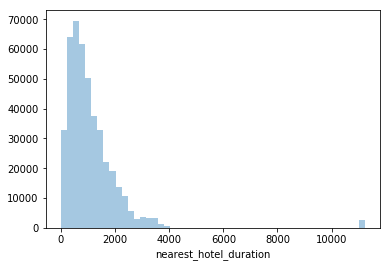

In [40]:
ax = sns.distplot(df_adressen_woning['nearest_hotel_duration'], kde=False)

Ideally this would be addressed at openstreetmap and temporarily solved by using as the crow flies for IJburg, but for the purpose of the analysis of the whole city, I'll exclude IJburg for now. Luckily IJburg is already nicely covered with 3 worm hotels.

In [58]:
df_adressen_woning_not_ijburg = df_adressen_woning[df_adressen_woning['Naam Wijk'].str.contains('IJburg') == False]

Also, openrouteservice.org seems to give much shorter times when calculating an isochrone than when using the router option. For example 'Amaliastraat 10' in Amsterdam is supposed to be less than 300 seconds away from the nearest hotel according to our earlier isochrone calculations, but according to their own router, it's a 480 second walk. That's a good explanation why the OSRM calculation shows much less worm hotels within a 5 minute walk radius.

If I expand the radius of the OSRM calculation to 500 seconds, I get about the same distribution as I got from the isochrone calculation. I think 500 seconds is a good upper maximum: an 8 minute walk is doable for early adopters, and by bike it's even faster.

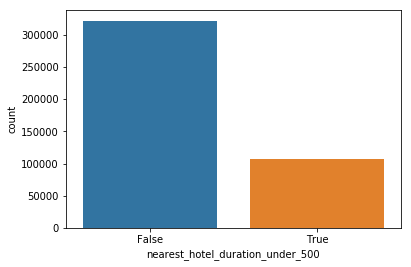

In [59]:
len(df_adressen_woning_not_ijburg)
df_adressen_woning_not_ijburg['nearest_hotel_duration_under_500'] = df_adressen_woning_not_ijburg['nearest_hotel_duration'].transform(lambda x: x < 500.5)
df_adressen_woning_not_ijburg.nearest_hotel_duration_under_500.value_counts()
p = sns.countplot(data=df_adressen_woning_not_ijburg, x = 'nearest_hotel_duration_under_500')



### 2.7 Percentages, histograms, and bins

The percentage of the number of hotels within a 500 second radius according to OSRM is 33.3%:


In [60]:
str(int((df_adressen_woning_not_ijburg.nearest_hotel_duration_under_500.value_counts()[1] / df_adressen_woning_not_ijburg.nearest_hotel_duration_under_500.value_counts()[0]) * 1000) / 10) + "%"

'33.3%'

Looking at the histogram, I see a lot of times below 1000 seconds (16.7 minutes).

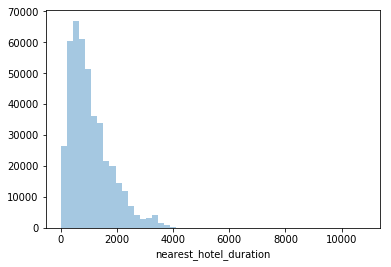

In [61]:
ax = sns.distplot(df_adressen_woning_not_ijburg['nearest_hotel_duration'], kde=False)

Let's zoom in on the most comon durations:

In [62]:
woning_ijburg_durations_below_3000 = df_adressen_woning_not_ijburg['nearest_hotel_duration'][df_adressen_woning_not_ijburg['nearest_hotel_duration'] < 3000]

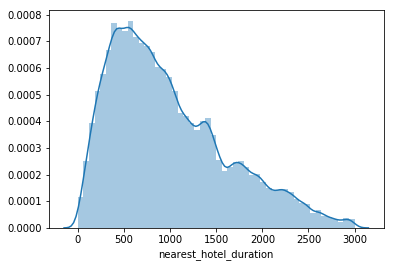

In [63]:
ax = sns.distplot(woning_ijburg_durations_below_3000)

And use our own bins:

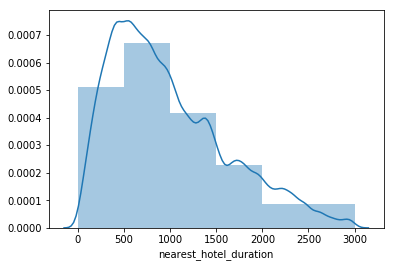

In [64]:
ax = sns.distplot(woning_ijburg_durations_below_3000, bins=[0, 500, 1000, 1500, 2000,3000])



### 2.7 Mapping the OSRM output: creating a chloropleth per neighbourhood

Let's compute the average duration per (larger) neighbourhood, normalize that into a score, and create a cloropleth map. I used the so called 'gebiedsgerichtwerkengebied', a larger neighbourhood, instead of 'normal' neighbourhoods, because [the address data of the municipality](https://data.amsterdam.nl/#?dsd=bag&dsp=1&dsv=TABLE&mpb=topografie&mpz=11&mpv=52.3731081:4.8932945) is out of date with [the 'new' neighbourhood borders of 2015](https://www.ois.amsterdam.nl/nieuwsarchief/2015/nieuwe-gebiedsindeling-voor-amsterdam).

#### Pivot table

First, I'll create a pivot table of the neigbourhoods and mean walking duration in seconds:

In [65]:
df_neighbourhood_nearest_hotel_duration =  df_adressen_woning_not_ijburg.pivot_table( \
                                        columns='Naam gebiedsgerichtwerkengebied', values='nearest_hotel_duration').transpose()
df_neighbourhood_nearest_hotel_duration.sort_values(by="nearest_hotel_duration")
len(df_neighbourhood_nearest_hotel_duration.sort_values(by="nearest_hotel_duration"))

22

#### Plotting mean neighbourhoods with a mean duration of < 500 seconds

Now I can also see the percentage of neighbourhoods where the mean walking time for residence addresses is less than 500 seconds (17.7%)

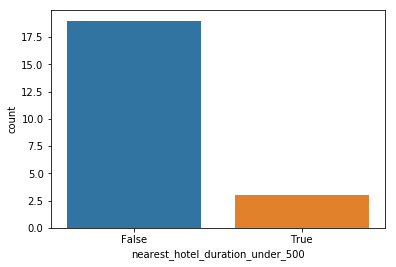

In [66]:
df_neighbourhood_nearest_hotel_duration['nearest_hotel_duration_under_500'] = \
df_neighbourhood_nearest_hotel_duration['nearest_hotel_duration'].transform(lambda x: x < 500.5)
len(df_neighbourhood_nearest_hotel_duration)
df_neighbourhood_nearest_hotel_duration.nearest_hotel_duration_under_500.value_counts()

"Percentage neighbourhoods under 500 second walk: " + str(df_neighbourhood_nearest_hotel_duration.nearest_hotel_duration_under_500.value_counts()[1] / len(df_neighbourhood_nearest_hotel_duration) * 100) + "%" 



p = sns.countplot(data=df_neighbourhood_nearest_hotel_duration, x = 'nearest_hotel_duration_under_500')

#### Normalizing the duration data

To make the cloropleth useful, I'll normalize the data to an inversed score, so that a shorter mean duration translates to a higher score.

In [68]:
df_neighbourhood_nearest_hotel_duration['nearest_hotel_duration_normalized'] = \
    df_neighbourhood_nearest_hotel_duration['nearest_hotel_duration'].transform(
    lambda x: 1 - (x - x.min()) / (x.max() - x.min()))
df_neighbourhood_nearest_hotel_duration.sort_values(by="nearest_hotel_duration_normalized", ascending=False)

nearest_hotel_duration  \
Naam gebiedsgerichtwerkengebied                                  
Indische Buurt / Oostelijk Havengebied              395.445561   
Westerpark                                          434.300928   
De Pijp / Rivierenbuurt                             494.153409   
Oud-Oost                                            516.719633   
Oud West / De Baarsjes                              562.601836   
Ijburg / Eiland Zeeburg                             676.957284   
Oud-Noord                                           793.821163   
Centrum-Oost                                        798.746384   
Watergraafsmeer                                     804.365915   
Bos en Lommer                                       848.735375   
Oud Zuid                                            902.842803   
Slotervaart                                         925.571860   
Centrum-West                                        937.145351   
Oost                                               1169.752248   
Gaasperdam / Driemond                              1290.230570   
West                                               1538.622201   
Buitenveldert / Zuidas                             1627.046032   
Osdorp                                             1775.954414   
Geuzenveld-Slotermeer-Sloterdijken                 1885.094372   
Bijlmer Centrum                                    2109.461601   
De Aker, Sloten en Nieuw Sloten                    2264.087821   
Bijlmer Oost                                       3200.194357   

                                        nearest_hotel_duration_under_500  \
Naam gebiedsgerichtwerkengebied                                            
Indische Buurt / Oostelijk Havengebied                              True   
Westerpark                                                          True   
De Pijp / Rivierenbuurt                                             True   
Oud-Oost                                                           False   
Oud West / De Baarsjes                                             False   
Ijburg / Eiland Zeeburg                                            False   
Oud-Noord                                                          False   
Centrum-Oost                                                       False   
Watergraafsmeer                                                    False   
Bos en Lommer                                                      False   
Oud Zuid                                                           False   
Slotervaart                                                        False   
Centrum-West                                                       False   
Oost                                                               False   
Gaasperdam / Driemond                                              False   
West                                                               False   
Buitenveldert / Zuidas                                             False   
Osdorp                                                             False   
Geuzenveld-Slotermeer-Sloterdijken                                 False   
Bijlmer Centrum                                                    False   
De Aker, Sloten en Nieuw Sloten                                    False   
Bijlmer Oost                                                       False   

                                        nearest_hotel_duration_normalized  
Naam gebiedsgerichtwerkengebied                                            
Indische Buurt / Oostelijk Havengebied                           1.000000  
Westerpark                                                       0.986147  
De Pijp / Rivierenbuurt                                          0.964807  
Oud-Oost                                                         0.956761  
Oud West / De Baarsjes                                           0.940402  
Ijburg / Eiland Zeeburg                                          0.899630  
Oud-Noord             

Let's set up a color scale, colormap function, and import the neighbourhood geojson.

In [69]:
from branca.colormap import linear

colormap = linear.YlGn.scale(
    df_neighbourhood_nearest_hotel_duration.nearest_hotel_duration_normalized.min(),
    df_neighbourhood_nearest_hotel_duration.nearest_hotel_duration_normalized.max())

print(colormap(5.0))

colormap

#005a32


In [70]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [71]:
m = folium.Map(location=[52.3824856,4.877951499999995], zoom_start=11, tiles='stamentoner',)


# folium.GeoJson(open("data/amsterdam-buurten-simplified-removed.geojson",encoding = "utf-8-sig").read(), name='geojson',
folium.GeoJson(open("data/amsterdam-gebiedsgerichtwerken.geojson",encoding = "utf-8-sig").read(), name='geojson',
    style_function=lambda feature: {
        'fillColor': colormap(df_neighbourhood_nearest_hotel_duration.loc[str(feature['properties']['titel'])]['nearest_hotel_duration_normalized']),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m)


m

In [72]:
InteractiveShell.ast_node_interactivity = "all" # Turn on all output again

### 2.8 Taking population into account

Let's create a score that takes the population of each neighbourhood into account. By multiplying the average duration with the population, I have another number that can instruct us where to put a new hotel. I'll create a new cloropleth and combine it with the isochrones to further help to figure out the best placement. I'll also create mouseovers to the map.

I used [this data from the municipality](https://data.amsterdam.nl/#?dte=catalogus%2Fapi%2F3%2Faction%2Fpackage_show%3Fid%3Db51154d8-2eca-4dd9-932d-63bca9ef0bf2&dtfs=T&dsf=groups::bevolking&mpb=topografie&mpz=11&mpv=52.3731081:4.8932945).

In [73]:
# Add the gebiedsgerichtwerkengebied code to the table
gebiedsgerichtwerkengebied_keys = df_adressen['Naam gebiedsgerichtwerkengebied'].unique()
gebiedsgerichtwerkengebied_values = df_adressen['Code gebiedsgerichtwerkengebied'].unique()
gebiedsgerichtwerkengebied_code_dict = dict(zip(gebiedsgerichtwerkengebied_keys, gebiedsgerichtwerkengebied_values))
df_neighbourhood_nearest_hotel_duration['Code gebied'] = \
    df_neighbourhood_nearest_hotel_duration.index.map(lambda x: gebiedsgerichtwerkengebied_code_dict[x])

In [74]:
# Import the population excel
df_population = pd.read_csv('data/goisbasisbestandenbasisstatistiekbestandnu-op-de-ois-sitedata.amsterdambbga_latest_and_greatest.zip', sep=";")
df_population_2018_gebieds = df_population[(df_population['jaar'] == 2018) & (df_population['variabele'] == 'BEVTOTAAL')]

/Users/jurian/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
# Add the population to the table
bevolking_keys = df_population_2018_gebieds.gebiedcode15.values
bevolking_values = df_population_2018_gebieds.waarde.values
bevolking_dict = dict(zip(bevolking_keys, bevolking_values))
df_neighbourhood_nearest_hotel_duration['Population'] = \
    df_neighbourhood_nearest_hotel_duration['Code gebied'].apply(lambda x: bevolking_dict[x])

In [76]:
df_neighbourhood_nearest_hotel_duration['Total seconds'] = \
    df_neighbourhood_nearest_hotel_duration['nearest_hotel_duration'] * \
        df_neighbourhood_nearest_hotel_duration['Population']

In [85]:
# Add normalized score
df_neighbourhood_nearest_hotel_duration['Total seconds normalized'] = \
    df_neighbourhood_nearest_hotel_duration['Total seconds'].transform(
    lambda x: 1 - (x - x.min()) / (x.max() - x.min()))

    # Add rank according to scores
df_neighbourhood_nearest_hotel_duration['Rank - Duration'] = pd.to_numeric(df_neighbourhood_nearest_hotel_duration['nearest_hotel_duration_normalized'].rank(ascending=False),downcast='integer')
df_neighbourhood_nearest_hotel_duration['Rank - Total Seconds'] = pd.to_numeric(df_neighbourhood_nearest_hotel_duration['Total seconds normalized'].rank(ascending=False),downcast='integer')

# Housekeeping
df_ranks = df_neighbourhood_nearest_hotel_duration.rename(columns={'nearest_hotel_duration': 'Mean duration', "nearest_hotel_duration_under_500": 'Mean duration < 500', "nearest_hotel_duration_normalized": "Mean duration normalized"})
df_ranks.drop(columns=['Mean duration < 500', 'Code gebied'], inplace=True)

#### Tables with ranks

As I can see, there are some notable shifts when I take population size into account. For example: even though 'Oud West / De Baarsjes' has a relatively small average walking duration to the nearest worm hotel, they still rank low in terms of total seconds to be walked, because so many people live there.

In [86]:
# Qgrid is nice a nice table display, but doesn't render in nbviewer, so I'll skip it here

# # import qgrid
# # # qgrid.QgridWidget(df=None, grid_options={'filterable': False}, precision=None, show_toolbar=None)
# # qgrid = qgrid.show_grid(df_ranks.sort_values('Rank - Total Seconds', ascending=False), grid_options={'filterable': False, 'maxVisibleRows': 23})
# # qgrid

In [87]:
df_ranks.sort_values('Rank - Total Seconds', ascending=False)

Mean duration  \
Naam gebiedsgerichtwerkengebied                         
Bijlmer Oost                              3200.194357   
Geuzenveld-Slotermeer-Sloterdijken        1885.094372   
Osdorp                                    1775.954414   
De Aker, Sloten en Nieuw Sloten           2264.087821   
West                                      1538.622201   
Bijlmer Centrum                           2109.461601   
Oud Zuid                                   902.842803   
Gaasperdam / Driemond                     1290.230570   
Buitenveldert / Zuidas                    1627.046032   
Oud West / De Baarsjes                     562.601836   
Centrum-West                               937.145351   
Slotervaart                                925.571860   
Centrum-Oost                               798.746384   
Oost                                      1169.752248   
De Pijp / Rivierenbuurt                    494.153409   
Bos en Lommer                              848.735375   
Watergraafsmeer                            804.365915   
Oud-Noord                                  793.821163   
Oud-Oost                                   516.719633   
Ijburg / Eiland Zeeburg                    676.957284   
Indische Buurt / Oostelijk Havengebied     395.445561   
Westerpark                                 434.300928   

                                        Mean duration normalized  Population  \
Naam gebiedsgerichtwerkengebied                                                
Bijlmer Oost                                            0.000000     28848.0   
Geuzenveld-Slotermeer-Sloterdijken                      0.468883     45940.0   
Osdorp                                                  0.507796     39312.0   
De Aker, Sloten en Nieuw Sloten                         0.333758     28541.0   
West                                                    0.592414     37851.0   
Bijlmer Centrum                                         0.388888     25008.0   
Oud Zuid                                                0.819094     54235.0   
Gaasperdam / Driemond                                   0.680975     34143.0   
Buitenveldert / Zuidas                                  0.560887     26280.0   
Oud West / De Baarsjes                                  0.940402     73117.0   
Centrum-West                                            0.806863     43386.0   
Slotervaart                                             0.810990     41988.0   
Centrum-Oost                                            0.856208     43465.0   
Oost                                                    0.723930     29365.0   
De Pijp / Rivierenbuurt                                 0.964807     65033.0   
Bos en Lommer                                           0.838385     35009.0   
Watergraafsmeer                                         0.854204     34119.0   
Oud-Noord                                               0.857964     29059.0   
Oud-Oost                                                0.956761     35846.0   
Ijburg / Eiland Zeeburg                                 0.899630     26062.0   
Indische Buurt / Oostelijk Havengebied                  1.000000     41427.0   
Westerpark                                              0.986147     36084.0   

                                        Total seconds  \
Naam gebiedsgerichtwerkengebied                         
Bijlmer Oost                             9.231921e+07   
Geuzenveld-Slotermeer-Sloterdijken       8.660124e+07   
Osdorp                                   6.981632e+07   
De Aker, Sloten en Nieuw Sloten          6.461933e+07   
West                                     5.823839e+07   
Bijlmer Centrum                          5.275342e+07   
Oud Zuid                                 4.896568e+07   
Gaasperdam / Driemond                    4.405234e+07   
Buitenveldert / Zuidas                   4.275877e+07   
Oud West / De Baarsjes                   4.113576e+07   
Centrum-West                             4.065899e+07   
Slotervaa

In [82]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [83]:
import branca.colormap

colormap = linear.YlGn.scale(
    df_ranks['Total seconds normalized'].min(),
    df_ranks['Total seconds normalized'].max())

print(colormap(5.0))

colormap


#005a32


In [84]:
m = folium.Map(location=[52.3824856,4.877951499999995], zoom_start=11, tiles='stamentoner',)

totalsecondslayer = folium.FeatureGroup(name="By Total Seconds")

totalsecondslayer.add_child(folium.GeoJson(open("data/amsterdam-gebiedsgerichtwerken.geojson",encoding = "utf-8-sig").read(), name='geojson',
    style_function=lambda feature: {
        'fillColor': colormap(df_ranks.loc[str(feature['properties']['titel'])]['Total seconds normalized']),
        'color': 'black',
        'weight': 1,
#         'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
#     highlight_function =lambda feature: { 'name': feature['properties']['titel']}
))

m.add_child(totalsecondslayer)
m

Complex Leaflet maps don't run in Jupyter, but [here is a map showing both layers](wormhotelmap.html) with popups.

And here is a screenshot of the maps side by side:

![](cloropleths-side-by-side.png)


## Conclusion

Right now, the worm hotels are placed on neighbourhood initiative, and it's apparent that some neighbourhoods get left out this way. My recommendation would be to promote the possibility of a worm hotel to people in the neighbourhoods with the highest score in the 'Mean duration' column, but to also take the 'Total seconds' column into account.

Feel free to email me at jur [at] jurb dot me for details.